Current device: cpu
Searching for files...

Dataset Statistics (Total: 242036)
- Training Set (Train): 154902
- Validation Set (Val) : 38726
- Test Set (Test)      : 48408


Starting Training (Max Epochs: 50)...
Epoch [1/50] Train Loss: 2.7542, Val Loss: 1.7853
Validation loss decreased (inf --> 1.785258). Saving model...
Epoch [2/50] Train Loss: 1.6911, Val Loss: 1.5391
Validation loss decreased (1.785258 --> 1.539093). Saving model...
Epoch [3/50] Train Loss: 1.5738, Val Loss: 1.4542
Validation loss decreased (1.539093 --> 1.454229). Saving model...
Epoch [4/50] Train Loss: 1.5269, Val Loss: 1.4276
Validation loss decreased (1.454229 --> 1.427632). Saving model...
Epoch [5/50] Train Loss: 1.4720, Val Loss: 1.3636
Validation loss decreased (1.427632 --> 1.363623). Saving model...
Epoch [6/50] Train Loss: 1.4347, Val Loss: 1.4159
EarlyStopping counter: 1 out of 6
Epoch [7/50] Train Loss: 1.3979, Val Loss: 1.2875
Validation loss decreased (1.363623 --> 1.287525). Saving model...
Epoch [

  0%|          | 0/20 [00:00<?, ?it/s]

SHAP plot saved
3. Conducting Biological Significance Analysis (Pathway, Cancer & Tissue)...
✅ Predicted Sensitivity by Target Pathway plot saved
✅ Predicted Sensitivity by Cancer Type plot saved
✅ Predicted Sensitivity by Tissue Type plot saved
4. Plotting Virtual Screening Heatmap...
✅ Virtual screening heatmap saved (virtual_screening.png)

Prediction Scenario: Drug [1003] vs New Cell (LUAD/lung)
⚠️ Warning: Exact match for LUAD+lung not found, relaxing conditions...
Found 62 similar cells as baseline...
Prediction Complete!
Predicted LN_IC50: -1.1924 (± 1.3075)

Prediction Scenario: Drug [1047] vs New Cell (LUAD/lung)
⚠️ Warning: Exact match for LUAD+lung not found, relaxing conditions...
Found 62 similar cells as baseline...
Prediction Complete!
Predicted LN_IC50: 4.7000 (± 0.8257)

Done!


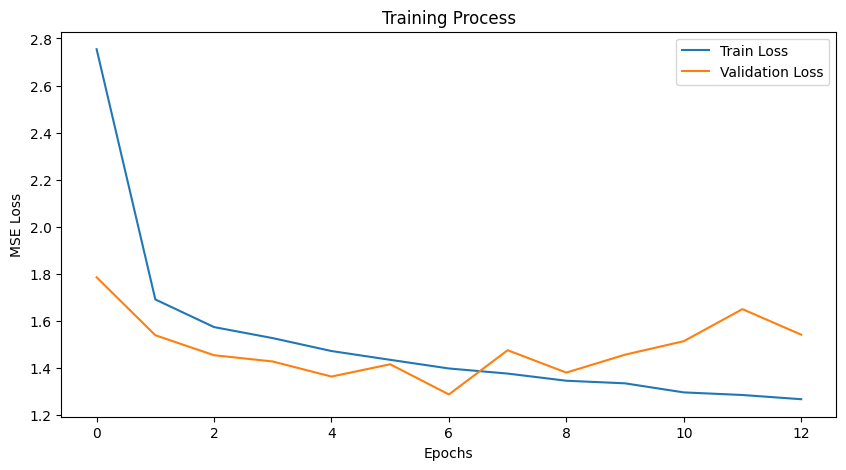

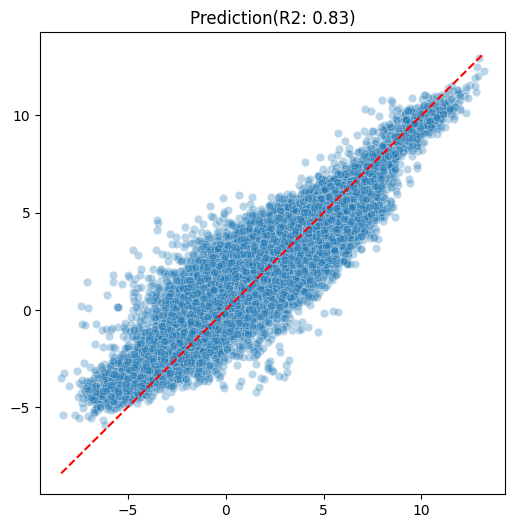

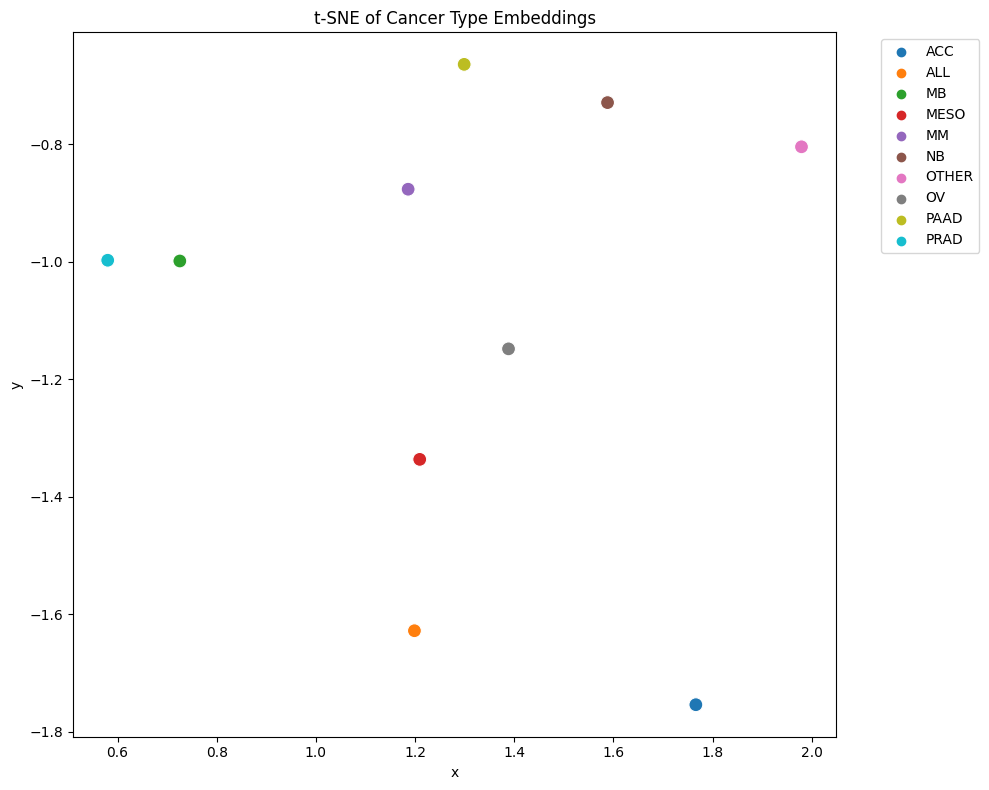

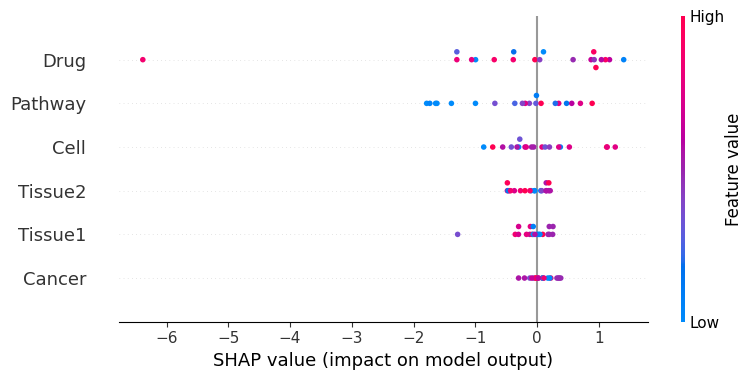

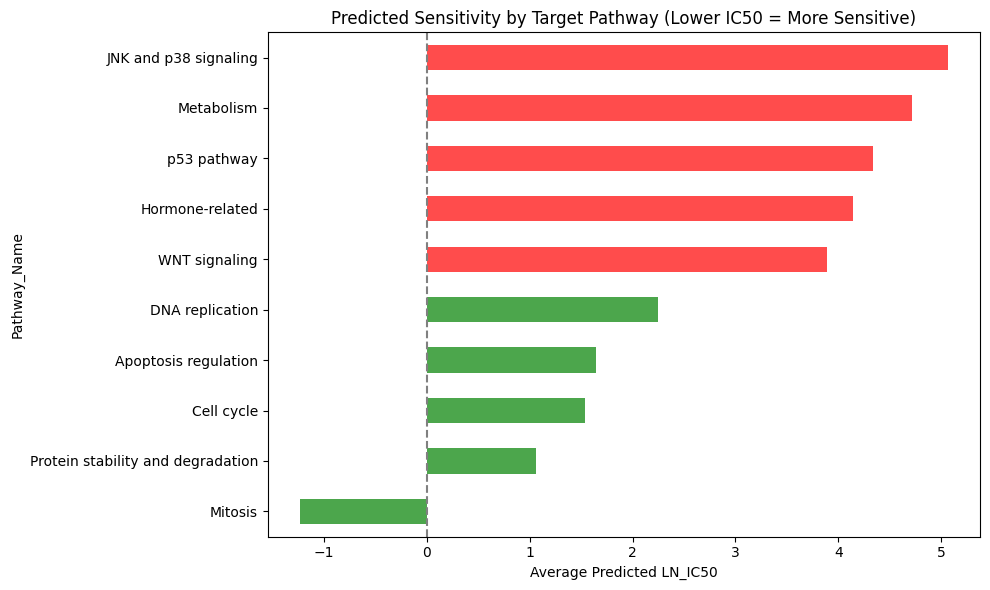

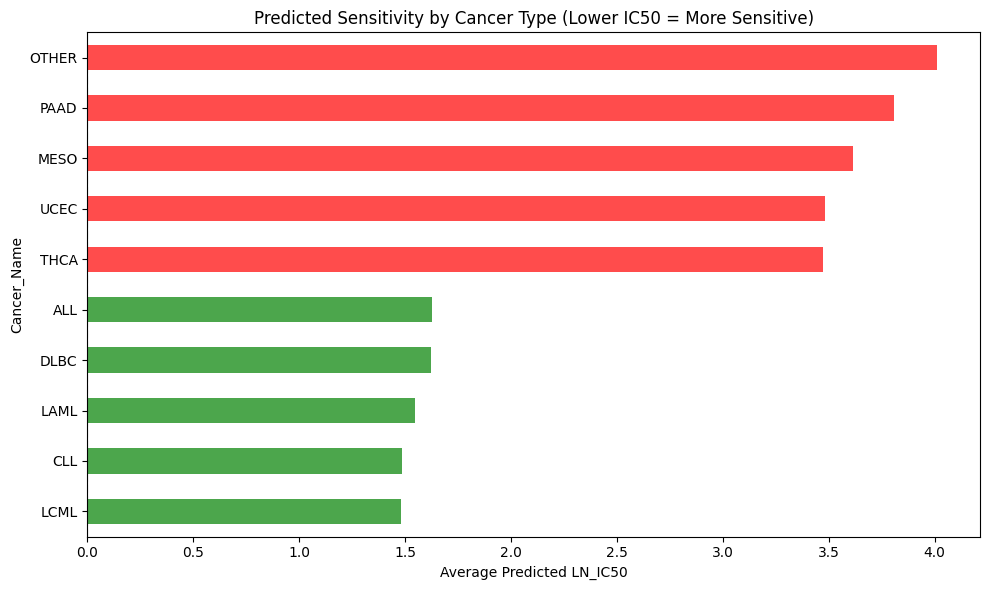

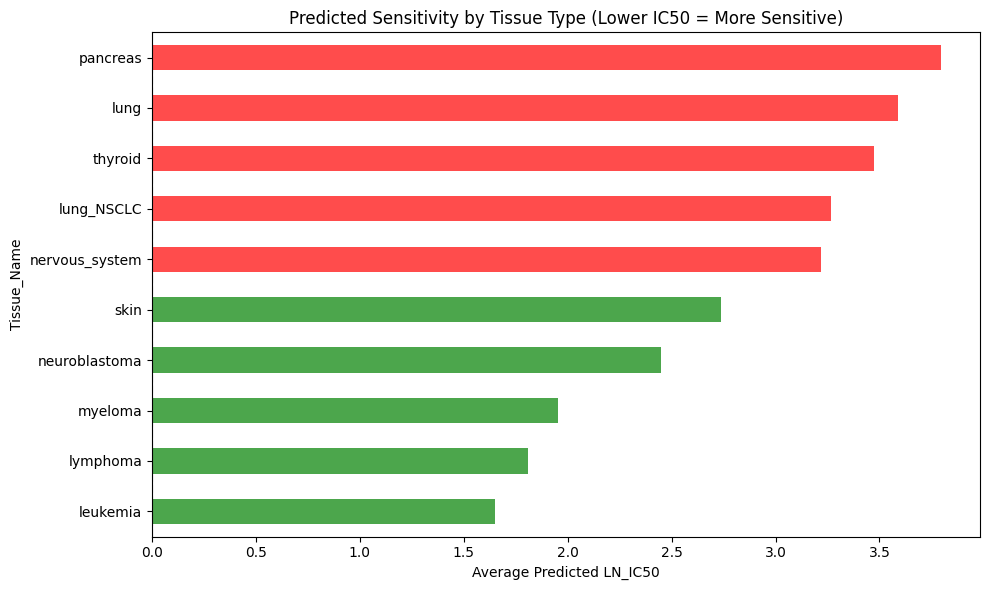

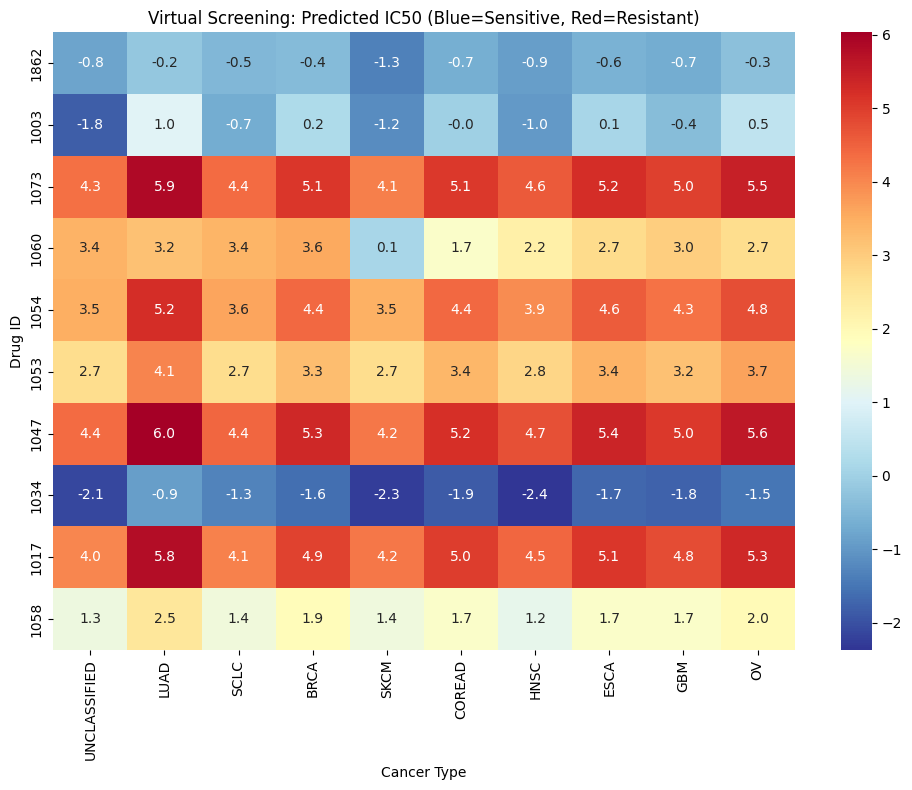

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import shap
import sys

# Ignore warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'batch_size': 256,
    'learning_rate': 0.001,
    'epochs': 50,
    'patience': 6,
    'emb_dim': 64,
    'test_size': 0.2,
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Current device: {CONFIG['device']}")

# ==========================================
# 2. Early Stopping Mechanism
# ==========================================
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# ==========================================
# 3. Data Processing
# ==========================================
class DrugDataProcessor:
    def __init__(self):
        self.encoders = {}
        self.raw_df_cache = None

    def clean_column_name(self, col_name):
        return col_name.replace('\n', ' ').strip() if isinstance(col_name, str) else col_name

    def load_and_process(self):
        print("Searching for files...")
        path_main = './data/GDSC2-dataset.csv'
        path_drug = './data/Compounds-annotation.csv'
        path_cell = './data/Cell_Lines_Details.xlsx'

        if not (path_main and path_drug and path_cell):
            print("❌ Error: Data files not found")

        df_main = pd.read_csv(path_main)
        df_drug = pd.read_csv(path_drug)
        df_cell = pd.read_excel(path_cell)
        df_cell.columns = [self.clean_column_name(c) for c in df_cell.columns]

        # Merge Logic
        df_main['DRUG_ID'] = pd.to_numeric(df_main['DRUG_ID'], errors='coerce')
        df_drug['DRUG_ID'] = pd.to_numeric(df_drug['DRUG_ID'], errors='coerce')
        data = pd.merge(df_main, df_drug[['DRUG_ID', 'TARGET_PATHWAY']], on='DRUG_ID', how='left')

        col_map = {}
        for c in df_cell.columns:
            if 'COSMIC' in c.upper(): col_map[c] = 'COSMIC_ID'
            elif 'TCGA' in c.upper(): col_map[c] = 'TCGA_DESC'
            elif 'Tissue descriptor 1' in c: col_map[c] = 'TISSUE1'
            elif 'Tissue descriptor 2' in c: col_map[c] = 'TISSUE2'

        df_cell = df_cell.rename(columns=col_map)
        for c in ['TCGA_DESC', 'TISSUE1', 'TISSUE2']:
            if c not in df_cell.columns: df_cell[c] = 'Unknown'

        data['COSMIC_ID'] = pd.to_numeric(data['COSMIC_ID'], errors='coerce')
        df_cell['COSMIC_ID'] = pd.to_numeric(df_cell['COSMIC_ID'], errors='coerce')

        data = pd.merge(data, df_cell[['COSMIC_ID', 'TCGA_DESC', 'TISSUE1', 'TISSUE2']], on='COSMIC_ID', how='left')

        if 'TCGA_DESC_x' in data.columns:
            data['TCGA_DESC'] = data['TCGA_DESC_x'].fillna(data['TCGA_DESC_y'])

        data = data.dropna(subset=['LN_IC50'])
        for c in ['TARGET_PATHWAY', 'TCGA_DESC', 'TISSUE1', 'TISSUE2']:
            data[c] = data[c].fillna('Unknown')

        self.raw_df_cache = data.copy()

        encode_cols = ['DRUG_ID', 'COSMIC_ID', 'TARGET_PATHWAY', 'TCGA_DESC', 'TISSUE1', 'TISSUE2']
        for col in encode_cols:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            self.encoders[col] = le

        return data[encode_cols + ['LN_IC50']]

# ==========================================
# 4. Dataset & Model
# ==========================================
class DrugSensitivityDataset(Dataset):
    def __init__(self, df):
        # Convert to Tensor in advance for speed
        self.drug_ids = torch.tensor(df['DRUG_ID'].values, dtype=torch.long)
        self.cell_ids = torch.tensor(df['COSMIC_ID'].values, dtype=torch.long)
        self.pathways = torch.tensor(df['TARGET_PATHWAY'].values, dtype=torch.long)
        self.cancer_types = torch.tensor(df['TCGA_DESC'].values, dtype=torch.long)
        self.tissue1 = torch.tensor(df['TISSUE1'].values, dtype=torch.long)
        self.tissue2 = torch.tensor(df['TISSUE2'].values, dtype=torch.long)
        self.targets = torch.tensor(df['LN_IC50'].values, dtype=torch.float32)

    def __len__(self): return len(self.targets)

    def __getitem__(self, idx):
        return {
            'drug': self.drug_ids[idx], 'cell': self.cell_ids[idx],
            'pathway': self.pathways[idx], 'cancer': self.cancer_types[idx],
            'tissue1': self.tissue1[idx], 'tissue2': self.tissue2[idx],
            'target': self.targets[idx]
        }

class DualTowerPredictor(nn.Module):
    def __init__(self, n_drugs, n_cells, n_path, n_cancer, n_t1, n_t2, emb_dim=64):
        super().__init__()
        self.drug_emb = nn.Embedding(n_drugs, emb_dim)
        self.path_emb = nn.Embedding(n_path, emb_dim)
        self.drug_tower = nn.Sequential(nn.Linear(emb_dim*2, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3))

        self.cell_emb = nn.Embedding(n_cells, emb_dim)
        self.cancer_emb = nn.Embedding(n_cancer, emb_dim)
        self.t1_emb = nn.Embedding(n_t1, emb_dim)
        self.t2_emb = nn.Embedding(n_t2, emb_dim)
        self.cell_tower = nn.Sequential(nn.Linear(emb_dim*4, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3))

        self.predictor = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 1))

    def forward(self, d, c, p, ca, t1, t2):
        d_feat = self.drug_tower(torch.cat([self.drug_emb(d), self.path_emb(p)], dim=1))
        c_feat = self.cell_tower(torch.cat([self.cell_emb(c), self.cancer_emb(ca), self.t1_emb(t1), self.t2_emb(t2)], dim=1))
        return self.predictor(torch.cat([d_feat, c_feat], dim=1)).squeeze()

# ==========================================
# 5. XAI Comprehensive Analysis Module
# ==========================================
def analyze_biological_significance(model, processor, test_df, device):
    print("3. Conducting Biological Significance Analysis (Pathway, Cancer & Tissue)...")

    pathway_enc = processor.encoders['TARGET_PATHWAY']
    tissue_enc = processor.encoders['TISSUE1']
    cancer_enc = processor.encoders['TCGA_DESC']

    model.eval()
    test_tensor_data = {
        'drug': torch.tensor(test_df['DRUG_ID'].values, dtype=torch.long).to(device),
        'cell': torch.tensor(test_df['COSMIC_ID'].values, dtype=torch.long).to(device),
        'pathway': torch.tensor(test_df['TARGET_PATHWAY'].values, dtype=torch.long).to(device),
        'cancer': torch.tensor(test_df['TCGA_DESC'].values, dtype=torch.long).to(device),
        'tissue1': torch.tensor(test_df['TISSUE1'].values, dtype=torch.long).to(device),
        'tissue2': torch.tensor(test_df['TISSUE2'].values, dtype=torch.long).to(device),
    }

    with torch.no_grad():
        preds = model(test_tensor_data['drug'], test_tensor_data['cell'],
                      test_tensor_data['pathway'], test_tensor_data['cancer'],
                      test_tensor_data['tissue1'], test_tensor_data['tissue2']).cpu().numpy()

    analysis_df = pd.DataFrame({
        'Pathway_ID': test_df['TARGET_PATHWAY'].values,
        'Tissue_ID': test_df['TISSUE1'].values,
        'Cancer_ID': test_df['TCGA_DESC'].values,
        'Predicted_IC50': preds
    })

    analysis_df['Pathway_Name'] = pathway_enc.inverse_transform(analysis_df['Pathway_ID'])
    analysis_df['Tissue_Name'] = tissue_enc.inverse_transform(analysis_df['Tissue_ID'])
    analysis_df['Cancer_Name'] = cancer_enc.inverse_transform(analysis_df['Cancer_ID'])

        # --- Define Plotting Function (Bar Chart) ---
    def plot_sensitivity_bar(df, group_col, title, filename):
        plt.figure(figsize=(10, 6))
        # Calculate average IC50 and sort
        stats = df.groupby(group_col)['Predicted_IC50'].mean().sort_values()

        # Take top 5 sensitive and top 5 resistant
        top_sensitive = stats.head(5)
        top_resistant = stats.tail(5)

        # If total categories < 10, plot all; otherwise plot top/bottom
        if len(stats) <= 10:
            plot_data = stats
            # Color coding: Green for sensitive (below median), Red for resistant (above median)
            median_val = stats.median()
            colors = ['green' if x < median_val else 'red' for x in plot_data]
        else:
            plot_data = pd.concat([top_sensitive, top_resistant])
            colors = ['green']*5 + ['red']*5

        plot_data.plot(kind='barh', color=colors, alpha=0.7)
        plt.title(f'{title} (Lower IC50 = More Sensitive)')
        plt.xlabel('Average Predicted LN_IC50')
        plt.axvline(0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.savefig(filename)
        print(f"{title} plot saved")

    # Figure 1: Pathway Analysis
    plot_sensitivity_bar(analysis_df, 'Pathway_Name',
                        'Predicted Sensitivity by Target Pathway',
                        'bio_significance_pathway.png')

    # Figure 2: Cancer Type Analysis
    plot_sensitivity_bar(analysis_df, 'Cancer_Name',
                        'Predicted Sensitivity by Cancer Type',
                        'bio_significance_cancer.png')

    # Figure 3: Tissue Analysis
    plot_sensitivity_bar(analysis_df, 'Tissue_Name',
                        'Predicted Sensitivity by Tissue Type',
                        'bio_significance_tissue.png')

def plot_virtual_screening_heatmap(model, processor, device):
    print("4. Plotting Virtual Screening Heatmap...")
    raw_df = processor.raw_df_cache
    top_drugs = raw_df['DRUG_ID'].value_counts().head(10).index
    top_cancers = raw_df['TCGA_DESC'].value_counts().head(10).index

    heatmap_data = np.zeros((10, 10))
    drug_enc = processor.encoders['DRUG_ID']
    cancer_enc = processor.encoders['TCGA_DESC']

    drug_props = raw_df.groupby('DRUG_ID')['TARGET_PATHWAY'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    cancer_props = raw_df.groupby('TCGA_DESC')[['TISSUE1', 'TISSUE2']].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    dummy_cell = processor.encoders['COSMIC_ID'].transform([str(raw_df['COSMIC_ID'].iloc[0])])[0]

    model.eval()
    with torch.no_grad():
        for i, drug_name in enumerate(top_drugs):
            for j, cancer_name in enumerate(top_cancers):
                try:
                    d_id = drug_enc.transform([str(drug_name)])[0]
                    c_id = cancer_enc.transform([str(cancer_name)])[0]
                    path_name = drug_props.get(drug_name, 'Unknown')
                    t1_name = cancer_props.loc[cancer_name, 'TISSUE1']
                    t2_name = cancer_props.loc[cancer_name, 'TISSUE2']
                    p_id = processor.encoders['TARGET_PATHWAY'].transform([str(path_name)])[0]
                    t1_id = processor.encoders['TISSUE1'].transform([str(t1_name)])[0]
                    t2_id = processor.encoders['TISSUE2'].transform([str(t2_name)])[0]

                    pred = model(torch.tensor([d_id], device=device), torch.tensor([dummy_cell], device=device),
                               torch.tensor([p_id], device=device), torch.tensor([c_id], device=device),
                               torch.tensor([t1_id], device=device), torch.tensor([t2_id], device=device)).item()
                    heatmap_data[i, j] = pred
                except: pass

    plt.figure(figsize=(10, 8))
    drug_labels = [str(d) for d in top_drugs]
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlBu_r',
                xticklabels=top_cancers, yticklabels=drug_labels)
    plt.title('Virtual Screening: Predicted IC50 (Blue=Sensitive, Red=Resistant)')
    plt.xlabel('Cancer Type')
    plt.ylabel('Drug ID')
    plt.tight_layout()
    plt.savefig('virtual_screening.png')
    print("Virtual screening heatmap saved (virtual_screening.png)")

def run_full_analysis(model, processor, test_loader, test_df, device):
    print("\n" + "="*40 + "\nStarting Full XAI Analysis\n" + "="*40)

    # 1. t-SNE Visualization
    model.eval()
    emb_weights = model.cancer_emb.weight.data.cpu().numpy()
    limit = min(500, len(emb_weights))

    print("1. Plotting t-SNE (Cancer Embeddings)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, limit-1), init='pca', learning_rate='auto')
    embeddings_2d = tsne.fit_transform(emb_weights[:limit])
    labels = processor.encoders['TCGA_DESC'].inverse_transform(range(limit))

    plt.figure(figsize=(10, 8))
    top_c = pd.Series(labels).value_counts().head(10).index
    pdf = pd.DataFrame({'x':embeddings_2d[:,0], 'y':embeddings_2d[:,1], 'label':labels})
    pdf_filtered = pdf[pdf['label'].isin(top_c)]

    sns.scatterplot(data=pdf_filtered, x='x', y='y', hue='label', palette='tab10', s=100)
    plt.title('t-SNE of Cancer Type Embeddings')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('tsne_cancer.png')
    print("t-SNE plot saved")

    # 2. SHAP Analysis
    print("2. Calculating SHAP (Feature Importance)...")
    def predict_wrapper(data_numpy):
        data_tensor = torch.tensor(data_numpy, dtype=torch.long).to(device)
        with torch.no_grad():
            preds = model(
                data_tensor[:, 0], data_tensor[:, 1], data_tensor[:, 2],
                data_tensor[:, 3], data_tensor[:, 4], data_tensor[:, 5]
            )
        return preds.cpu().numpy().flatten()

    batch = next(iter(test_loader))
    bg = torch.stack([
        batch['drug'], batch['cell'], batch['pathway'],
        batch['cancer'], batch['tissue1'], batch['tissue2']
    ], dim=1).cpu().numpy()

    bg_summary = shap.kmeans(bg, 10)
    explainer = shap.KernelExplainer(predict_wrapper, bg_summary)
    shap_values = explainer.shap_values(bg[:20])

    plt.figure()
    shap.summary_plot(shap_values, bg[:20],
                     feature_names=['Drug', 'Cell', 'Pathway', 'Cancer', 'Tissue1', 'Tissue2'],
                     show=False)
    plt.savefig('shap_summary.png')
    print("SHAP plot saved")

    # 3. Biological Significance
    analyze_biological_significance(model, processor, test_df, device)

    # 4. Heatmap
    plot_virtual_screening_heatmap(model, processor, device)

# ==========================================
# 6. Inference Module for New Cells
# ==========================================
def predict_unknown_cell(model, processor, device,
                         drug_name, cancer_type, tissue1, tissue2,
                         target_pathway=None):
    # Predict response of unknown cells to known drugs
    print(f"\nPrediction Scenario: Drug [{drug_name}] vs New Cell ({cancer_type}/{tissue1})")

    model.eval()

    try:
        # Process Drug
        drug_id = processor.encoders['DRUG_ID'].transform([str(drug_name)])[0]

        if target_pathway is None:
            raw_df = processor.raw_df_cache
            # Lookup Pathway
            path_mode = raw_df[raw_df['DRUG_ID'] == int(drug_name)]['TARGET_PATHWAY'].mode()
            real_pathway = path_mode[0] if not path_mode.empty else 'Unknown'
        else:
            real_pathway = target_pathway

        path_id = processor.encoders['TARGET_PATHWAY'].transform([str(real_pathway)])[0]

    except ValueError:
        print(f"❌ Error: Drug ID [{drug_name}] not found")
        return None

    # Process Cell: Find similar cell groups
    raw_df = processor.raw_df_cache
    mask = (raw_df['TCGA_DESC'] == cancer_type) & (raw_df['TISSUE1'] == tissue1)
    if tissue2:
        mask = mask & (raw_df['TISSUE2'] == tissue2)

    matching_cells = raw_df[mask]['COSMIC_ID'].unique()

    if len(matching_cells) == 0:
        print(f"⚠️ Warning: Exact match for {cancer_type}+{tissue1} not found, relaxing conditions...")
        matching_cells = raw_df[raw_df['TCGA_DESC'] == cancer_type]['COSMIC_ID'].unique()

    if len(matching_cells) == 0:
        print("❌ Error: Reference cells not found.")
        return None

    print(f"Found {len(matching_cells)} similar cells as baseline...")

    # Prepare Batch
    n_samples = len(matching_cells)
    d_tensor = torch.full((n_samples,), drug_id, dtype=torch.long).to(device)
    p_tensor = torch.full((n_samples,), path_id, dtype=torch.long).to(device)

    encoded_cells = processor.encoders['COSMIC_ID'].transform(matching_cells.astype(str))
    c_tensor = torch.tensor(encoded_cells, dtype=torch.long).to(device)

    try:
        ca_id = processor.encoders['TCGA_DESC'].transform([str(cancer_type)])[0]
        t1_id = processor.encoders['TISSUE1'].transform([str(tissue1)])[0]
        t2_id = processor.encoders['TISSUE2'].transform([str(tissue2)])[0]
    except ValueError:
        print("❌ Error: Input cancer/tissue type does not exist")
        return None

    ca_tensor = torch.full((n_samples,), ca_id, dtype=torch.long).to(device)
    t1_tensor = torch.full((n_samples,), t1_id, dtype=torch.long).to(device)
    t2_tensor = torch.full((n_samples,), t2_id, dtype=torch.long).to(device)

    # Predict
    with torch.no_grad():
        preds = model(d_tensor, c_tensor, p_tensor, ca_tensor, t1_tensor, t2_tensor)
        avg_ln_ic50 = preds.mean().item()
        std_ln_ic50 = preds.std().item()

    print(f"Prediction Complete!")
    print(f"Predicted LN_IC50: {avg_ln_ic50:.4f} (± {std_ln_ic50:.4f})")
    return avg_ln_ic50

# ==========================================
# 7. Main Program
# ==========================================
def main():
    processor = DrugDataProcessor()
    df = processor.load_and_process()

    # ==========================================
    # 1. Data Splitting (Train / Val / Test)
    # ==========================================
    train_val_df, test_df = train_test_split(df, test_size=CONFIG['test_size'], random_state=CONFIG['seed'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=CONFIG['seed'])

    print("\n" + "="*40)
    print(f"Dataset Statistics (Total: {len(df)})")
    print(f"- Training Set (Train): {len(train_df)}")
    print(f"- Validation Set (Val) : {len(val_df)}")
    print(f"- Test Set (Test)      : {len(test_df)}")
    print("="*40 + "\n")

    # ==========================================
    # 2. Create Dataset and DataLoader
    # ==========================================
    train_dataset = DrugSensitivityDataset(train_df)
    val_dataset = DrugSensitivityDataset(val_df)
    test_dataset = DrugSensitivityDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    encs = processor.encoders
    n_params = {
        'n_drugs': len(encs['DRUG_ID'].classes_),
        'n_cells': len(encs['COSMIC_ID'].classes_),
        'n_path': len(encs['TARGET_PATHWAY'].classes_),
        'n_cancer': len(encs['TCGA_DESC'].classes_),
        'n_t1': len(encs['TISSUE1'].classes_),
        'n_t2': len(encs['TISSUE2'].classes_),
    }

    model = DualTowerPredictor(**n_params, emb_dim=CONFIG['emb_dim']).to(CONFIG['device'])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    early_stopping = EarlyStopping(patience=CONFIG['patience'], verbose=True)

    print(f"\nStarting Training (Max Epochs: {CONFIG['epochs']})...")

    train_losses, val_losses = [], []

    # ==========================================
    # 3. Training Loop
    # ==========================================
    for epoch in range(CONFIG['epochs']):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = {k: v.to(CONFIG['device']) for k, v in batch.items() if k != 'target'}
            target = batch['target'].to(CONFIG['device'])

            outputs = model(inputs['drug'], inputs['cell'], inputs['pathway'],
                          inputs['cancer'], inputs['tissue1'], inputs['tissue2'])
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(CONFIG['device']) for k, v in batch.items() if k != 'target'}
                target = batch['target'].to(CONFIG['device'])
                outputs = model(inputs['drug'], inputs['cell'], inputs['pathway'],
                              inputs['cancer'], inputs['tissue1'], inputs['tissue2'])
                val_loss += criterion(outputs, target).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        sys.stdout.flush()

        # Early Stopping check
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # ==========================================
    # 4. Final Evaluation
    # ==========================================
    print("\nLoading best model parameters with lowest Validation Loss...")
    model.load_state_dict(torch.load('checkpoint.pt'))

    print("\nPerforming Final Evaluation on Test Set...")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Process')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    print("Loss curve saved (loss_curve.png)")

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(CONFIG['device']) for k, v in batch.items() if k != 'target'}
            target = batch['target'].to(CONFIG['device'])
            outputs = model(inputs['drug'], inputs['cell'], inputs['pathway'],
                          inputs['cancer'], inputs['tissue1'], inputs['tissue2'])
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    mse = mean_squared_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    print(f"Final Test Results (Test Set) -> MSE: {mse:.4f}, R2 Score: {r2:.4f}")

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=all_targets, y=all_preds, alpha=0.3)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.title(f'Prediction(R2: {r2:.2f})')
    plt.savefig('prediction_scatter.png')
    print("Prediction scatter plot saved (prediction_scatter.png)")

    # Run full XAI suite (using Test Data)
    run_full_analysis(model, processor, test_loader, test_df, CONFIG['device'])

    # Run New Cell Prediction Demo
    predict_unknown_cell(model, processor, CONFIG['device'],
                         drug_name=1003, cancer_type='LUAD',
                         tissue1='lung', tissue2='lung_NSCLC_adenocarcinoma')

    predict_unknown_cell(model, processor, CONFIG['device'],
                         drug_name=1047, cancer_type='LUAD',
                         tissue1='lung', tissue2='lung_NSCLC_adenocarcinoma')

    print("\nDone!")

if __name__ == '__main__':
    main()